In [160]:
import pandas as pd
import numpy as np
import os
from os.path import isfile, join
import matplotlib.pyplot as plt

In [342]:
TRPL_folderpath = '/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 TRPL Maxim/BS'

In [343]:
os.listdir(TRPL_folderpath)

['M02t16-BS_3826-43000ns_300nsGate.asc',
 'M02t16-BS_80p3-835ns_2p5nsGate_dark.sif',
 'M02t16_24000-85700ns_2500nsGate_dark.asc',
 'M02t16-BS_638-5583ns_20nsGate.asc',
 'M02t16-BS_11p0-115ns_1p9nsGate_dark.asc',
 'M02t16-BS_80p3-835ns_2p5nsGate_dark.asc',
 'M02t16_3826-43000ns_300nsGate_dark.asc',
 'M02t16-BS_24000-85700ns_2500nsGate.asc',
 'M02t16-BS_11p0-115ns_1p9nsGate.sif',
 'M02t16-BS_638-5583ns_20nsGate_dark.sif',
 'M02t16-BS_80p3-835ns_2p5nsGate.asc',
 'M02t16-BS_24000-85700ns_2500nsGate.sif',
 'M02t16-BS_80p3-835ns_2p5nsGate.sif',
 'M02t16-BS_11p0-115ns_1p9nsGate_dark.sif',
 'M02t16-BS_638-5583ns_20nsGate_dark.asc',
 'M02t16-BS_3826-43000ns_300nsGate.sif',
 'M02t16-BS_638-5583ns_20nsGate.sif',
 'M02t16-BS_11p0-115ns_1p9nsGate.asc']

In [344]:
files = [f for f in os.listdir(TRPL_folderpath) if (isfile(join(TRPL_folderpath, f)) and f.endswith(".asc") and not (f.endswith("dark.asc")))]
files = np.array(files)
print(files)
delay0s = np.zeros((len(files),))
for i, f in enumerate(files):
    delay0s[i] = (float(f.split("_")[1].split("-")[0].replace("p", ".")))
inds = delay0s.argsort()
delay0s = delay0s[inds]
files = files[inds]

['M02t16-BS_3826-43000ns_300nsGate.asc'
 'M02t16-BS_638-5583ns_20nsGate.asc'
 'M02t16-BS_24000-85700ns_2500nsGate.asc'
 'M02t16-BS_80p3-835ns_2p5nsGate.asc' 'M02t16-BS_11p0-115ns_1p9nsGate.asc']


In [348]:
class trPL_withSpectra:
    def __init__(self, TRPL_folderpath):
        self.TRPL_folderpath = TRPL_folderpath
        self.TRPL_spcts_folder_read()
        self.generateData()
        self.stitch_trPL()
    
    def TRPL_spcts_folder_read(self):
        files = [f for f in os.listdir(self.TRPL_folderpath) if (isfile(join(self.TRPL_folderpath, f)) and f.endswith(".asc") and not(f.endswith("dark.asc")))]
        files = np.array(files)
        
        delay0s = np.zeros((len(files),))
        for i, f in enumerate(files):
            delay0s[i] = (float(f.split("_")[1].split("-")[0].replace("p", ".")))
        inds = delay0s.argsort()
        self.delay0s = delay0s[inds]
        self.files = files[inds]
    

        files_dark = [f for f in os.listdir(self.TRPL_folderpath) if (isfile(join(self.TRPL_folderpath, f)) and f.endswith("dark.asc"))]
        files_dark = np.array(files_dark)
        delay0s_dark = np.zeros((len(files),))
        for i, f in enumerate(files_dark):
            delay0s_dark[i] = (float(f.split("_")[1].split("-")[0].replace("p", ".")))
        inds = delay0s_dark.argsort()
        self.delay0s_dark = delay0s_dark[inds]
        self.files_dark = files_dark[inds]

    def generateData(self):
        
        preamble_dfs = []
        step_list = []
        trPLs_integral = []
        for i, f in enumerate(self.files):
            print("File", f)
            print("--- Dark", self.files_dark[i])
            # Measurement Meta-Data
            df_preamble = pd.read_csv(join(self.TRPL_folderpath, f), nrows=36, header=None, dtype=str, delimiter = '\t')
            preamble_dfs.append(df_preamble)
            time_step = 1e-12*float(df_preamble.iloc[32][0].split()[-1].split('exp')[0]) #s
            exp_factor = float(df_preamble.iloc[32][0].split()[-1].split('exp')[1][1:-2])
            gate_delay0 = 1e-9*float(df_preamble.iloc[31][0].split()[-1]) #ns
            len_series = int(df_preamble.iloc[9][0].split()[-1])

            # trPL Data
            df2 = pd.read_csv(join(self.TRPL_folderpath, f), header=36, delimiter = '\t', names=['lambdas', 'acc-counts'],  index_col=False)
            ls = df2['lambdas'].to_numpy()
            counts = df2['acc-counts'].to_numpy()
            diff = ls[1:]-ls[:-1]
            len_ls = np.argwhere(diff < 0)[0][0]+1
            #background
            bg = pd.read_csv(join(self.TRPL_folderpath, self.files_dark[i]), header=33, delimiter = '\t', names=['lambdas', 'acc-counts'],  index_col=False)

            trPL = np.zeros((len_series,))
            step_id = np.arange(len_series)
            steps = np.zeros_like(step_id, dtype=float)
            for j in step_id:
                if not(j):
                    steps[j] = gate_delay0
                else:
                    #print(steps[j-2] +  time_step*np.exp(exp_factor*i))
                    steps[j] = steps[j-1] +  time_step*np.exp(exp_factor*j)
                    
                trPL[j] = np.trapezoid(counts[j*len_ls:(j+1)*len_ls] - bg['acc-counts'], x = ls[j*len_ls:(j+1)*len_ls])

                plt.plot(ls[j*len_ls:(j+1)*len_ls], bg['acc-counts'])
                #plt.plot(ls[i*len_ls:(i+1)*len_ls], counts[i*len_ls:(i+1)*len_ls])

            trPLs_integral.append(trPL)
            step_list.append(steps)

        self.trPLs_integral = trPLs_integral
        self.step_list = step_list

    def stitch_trPL(self):
        stitch_t = np.array([])
        stitch_trPL = np.array([])
        scale = 1
        for i, (t, trPL) in enumerate(zip(self.step_list, self.trPLs_integral)):
            stitch_t = np.concatenate((stitch_t, t))
            if i:
                arg = np.argmin(np.abs(self.step_list[i-1] - t[0]))
                print(arg)
                scale = scale*self.trPLs_integral[i-1][arg]/np.amax(self.trPLs_integral[i-1])
            stitch_trPL = np.concatenate((stitch_trPL, scale*trPL/np.amax(trPL)))

        self.stitch_t = stitch_t
        self.stitch_trPL = stitch_trPL
        

File M02t16_11p0-115ns_1p9nsGate.asc
--- Dark M02t16_11p0-115ns_1p9nsGate_dark.asc
File M02t16_80p3-835ns_2p5nsGate_nextDay.asc
--- Dark M02t16_80p3-835ns_2p5nsGate(copy)_dark.asc
File M02t16_80p3-835ns_2p5nsGate.asc
--- Dark M02t16_80p3-835ns_2p5nsGate_dark.asc
File M02t16_638-5191ns_20nsGate.asc
--- Dark M02t16_638-5191ns_20nsGate_dark.asc
File M02t16_3826-43000ns_300nsGate.asc
--- Dark M02t16_3826-43000ns_300nsGate_dark.asc
File M02t16_24000-85700ns_2500nsGate.asc
--- Dark M02t16_24000-85700ns_2500nsGate_dark.asc
71
0
44
29
21


array(['M02t16_11p0-115ns_1p9nsGate.asc',
       'M02t16_80p3-835ns_2p5nsGate_nextDay.asc',
       'M02t16_80p3-835ns_2p5nsGate.asc',
       'M02t16_638-5191ns_20nsGate.asc',
       'M02t16_3826-43000ns_300nsGate.asc',
       'M02t16_24000-85700ns_2500nsGate.asc'], dtype='<U39')

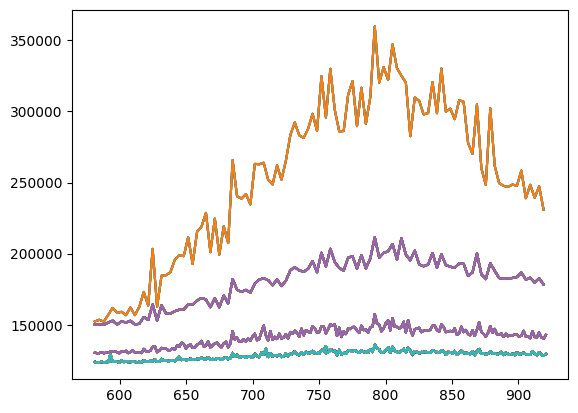

In [356]:
TRPL_folderpath = "/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 TRPL Maxim/FS"
trPLs = trPL_withSpectra(TRPL_folderpath)
trPLs.files

File M02t16-BS_11p0-115ns_1p9nsGate.asc
--- Dark M02t16-BS_11p0-115ns_1p9nsGate_dark.asc
File M02t16-BS_80p3-835ns_2p5nsGate.asc
--- Dark M02t16-BS_80p3-835ns_2p5nsGate_dark.asc
File M02t16-BS_638-5583ns_20nsGate.asc
--- Dark M02t16-BS_638-5583ns_20nsGate_dark.asc
File M02t16-BS_3826-43000ns_300nsGate.asc
--- Dark M02t16_3826-43000ns_300nsGate_dark.asc
File M02t16-BS_24000-85700ns_2500nsGate.asc
--- Dark M02t16_24000-85700ns_2500nsGate_dark.asc
71
44
29
21


array(['M02t16-BS_11p0-115ns_1p9nsGate.asc',
       'M02t16-BS_80p3-835ns_2p5nsGate.asc',
       'M02t16-BS_638-5583ns_20nsGate.asc',
       'M02t16-BS_3826-43000ns_300nsGate.asc',
       'M02t16-BS_24000-85700ns_2500nsGate.asc'], dtype='<U38')

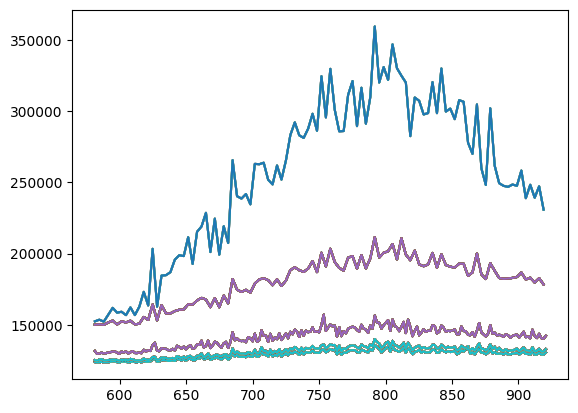

In [357]:
TRPL_folderpath_back = "/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 TRPL Maxim/BS"
trPLs_BS = trPL_withSpectra(TRPL_folderpath_back)
trPLs_BS.files

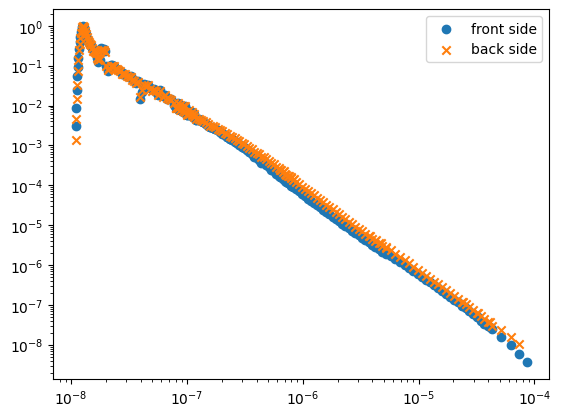

In [361]:
plt.scatter(trPLs.stitch_t, trPLs.stitch_trPL, label = "front side")
plt.scatter(trPLs_BS.stitch_t, trPLs_BS.stitch_trPL, label = "back side", marker = "x")
plt.yscale("log")
plt.xscale("log")
plt.legend()